In [2]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [3]:
### Tools to get max and second max proba with corresponding components

add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [4]:
### Tools to launch HDP and get results

launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [5]:
df_final <- read.table("modif_final.tsv")

In [6]:
table(df_final$inv_3)


   0    1 
2128   22 

In [7]:
### Tools for distributions of HDP


num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


# I) Initial Component : Component 0 to 10

In [16]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 0.5
ab <-1.5

Initialise HDP on a 2150 x 153 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 750 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of 

,values,count,freq
2,1,833,38.7441860465116
3,2,418,19.4418604651163
4,3,229,10.6511627906977
5,4,128,5.95348837209302
6,5,114,5.30232558139535
7,6,114,5.30232558139535
1,0,96,4.46511627906977
9,8,61,2.83720930232558
12,NaN,51,2.37209302325581
8,7,50,2.32558139534884


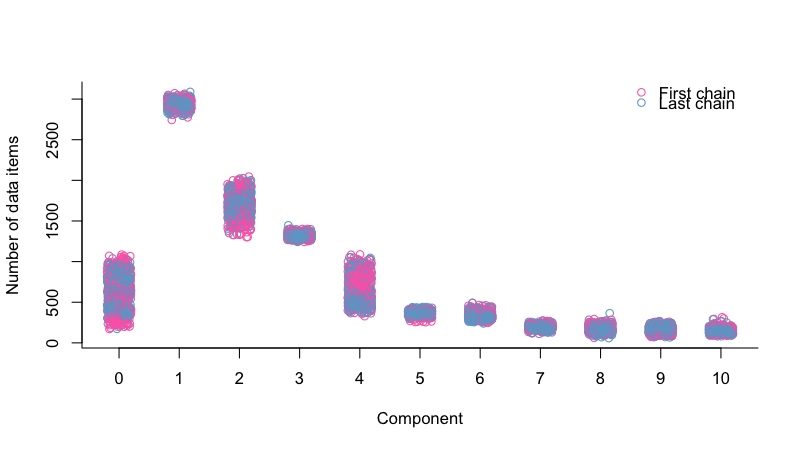

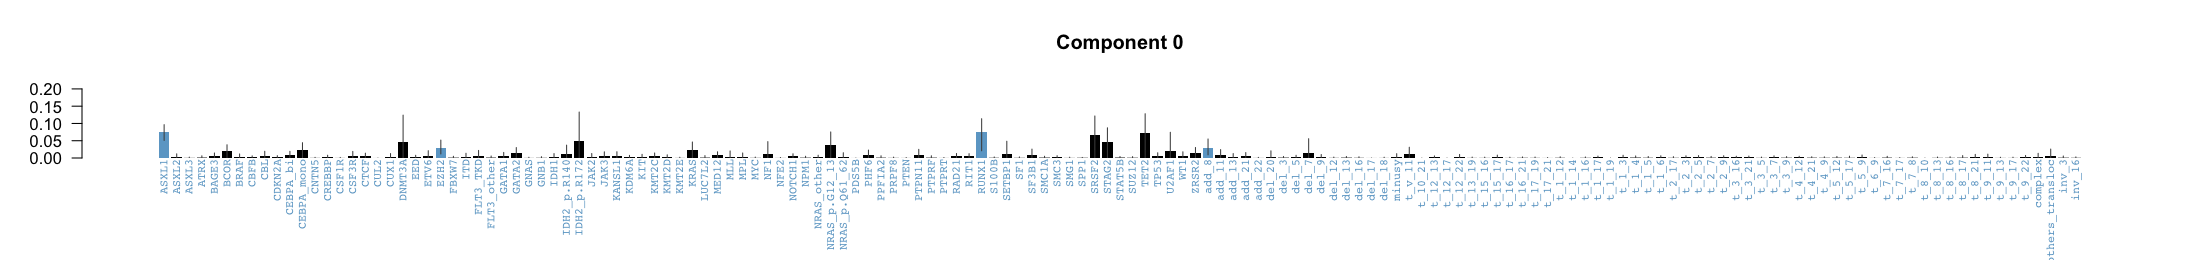

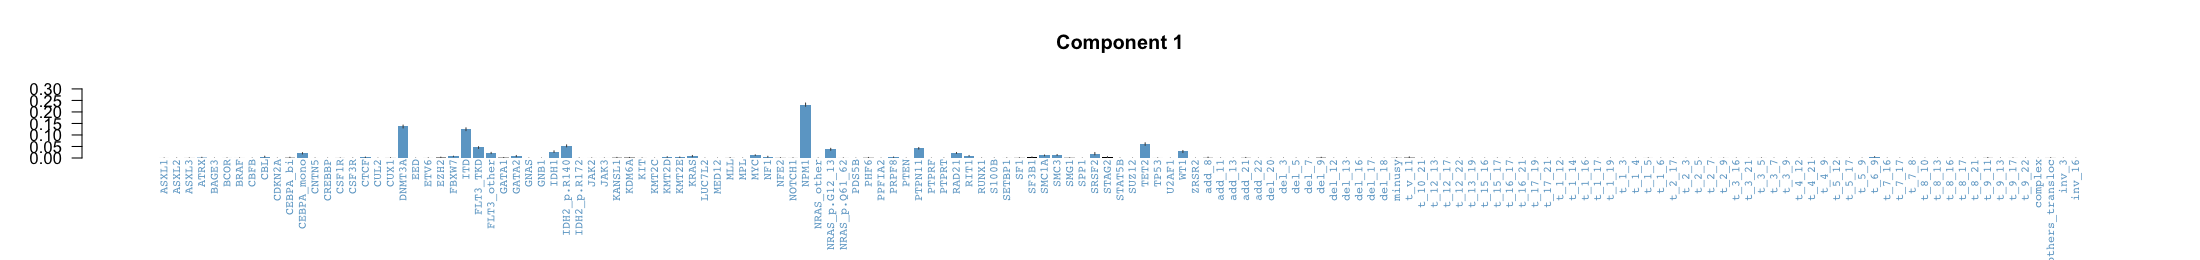

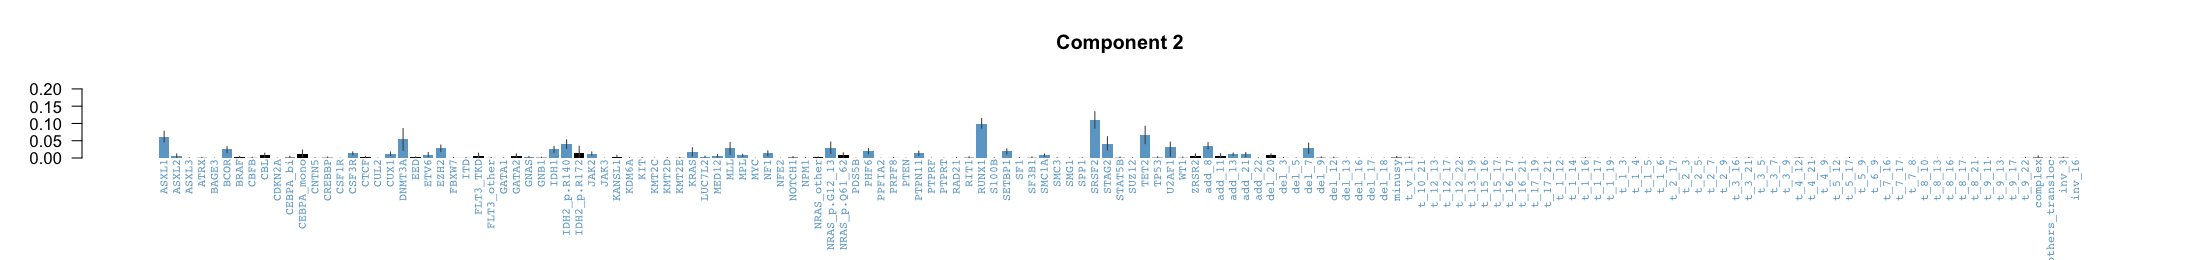

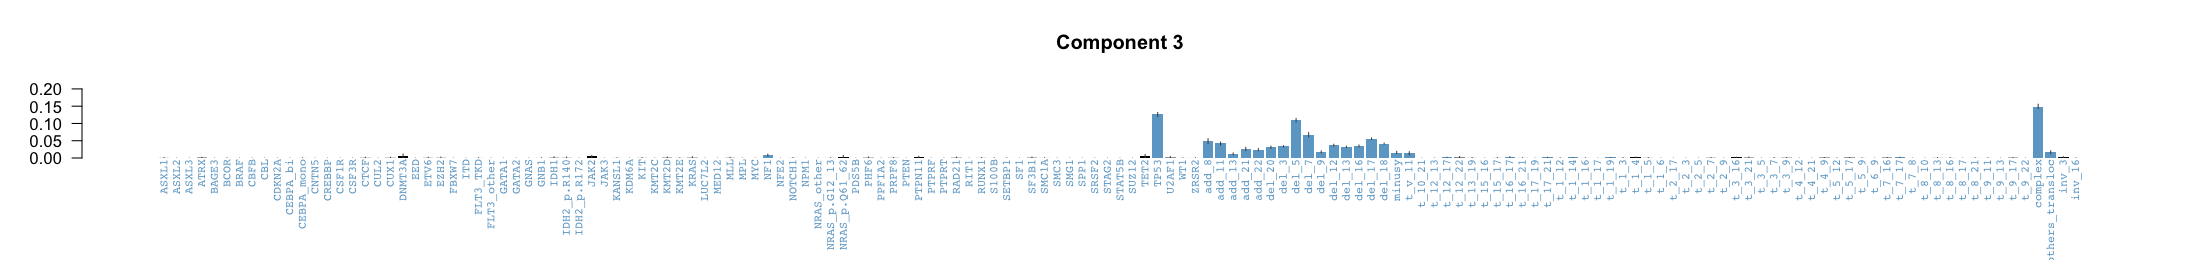

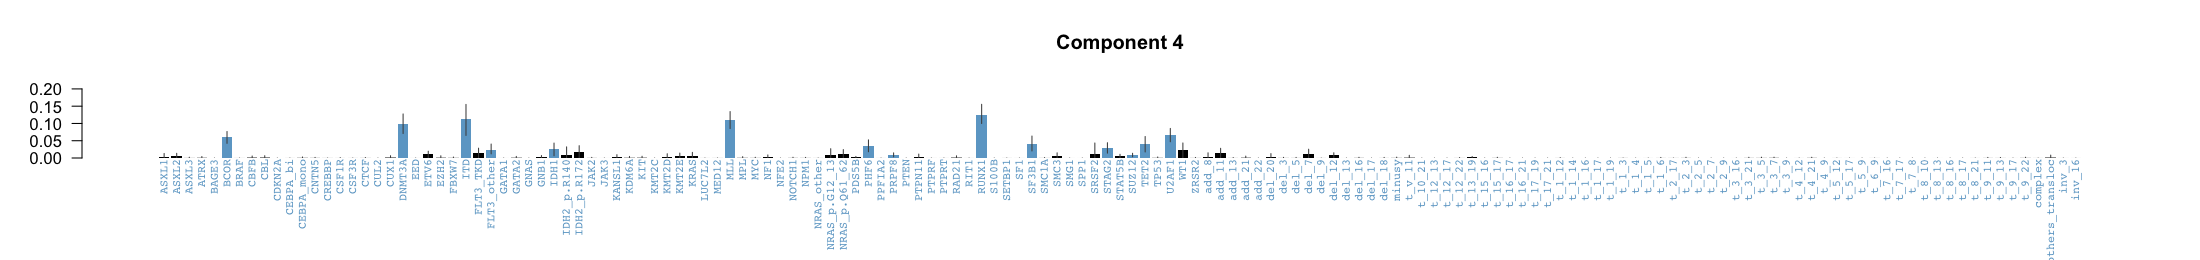

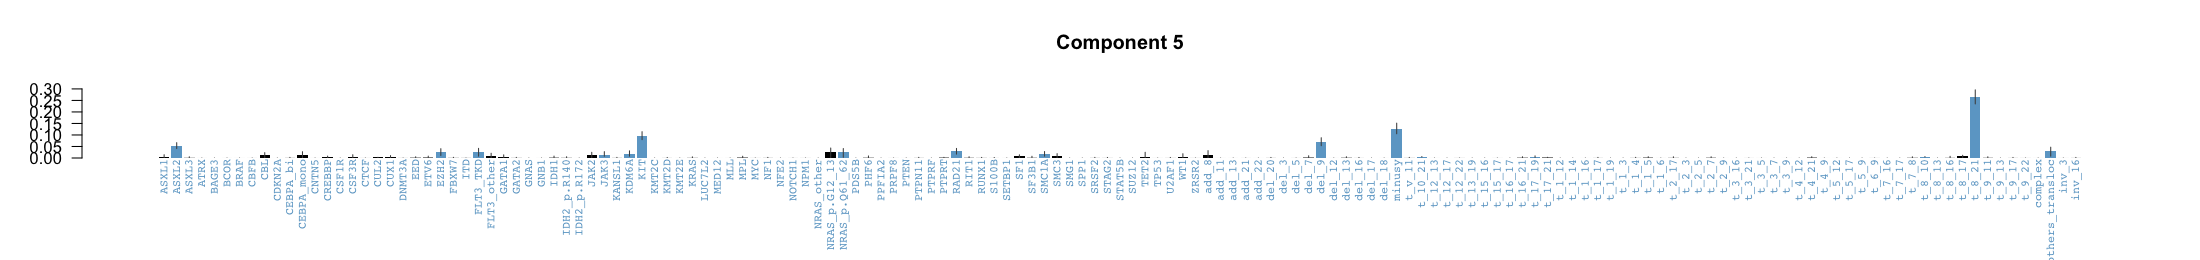

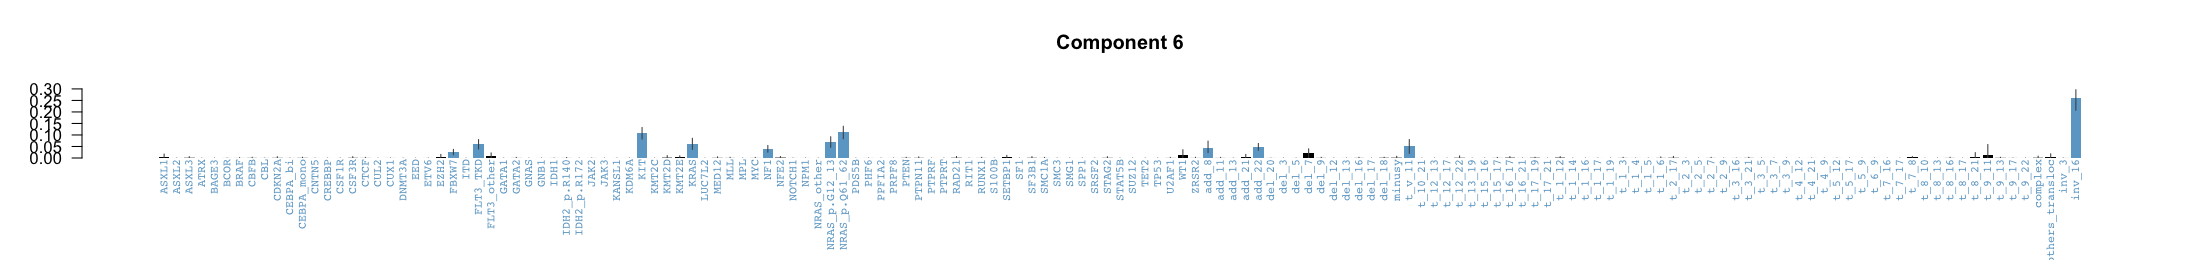

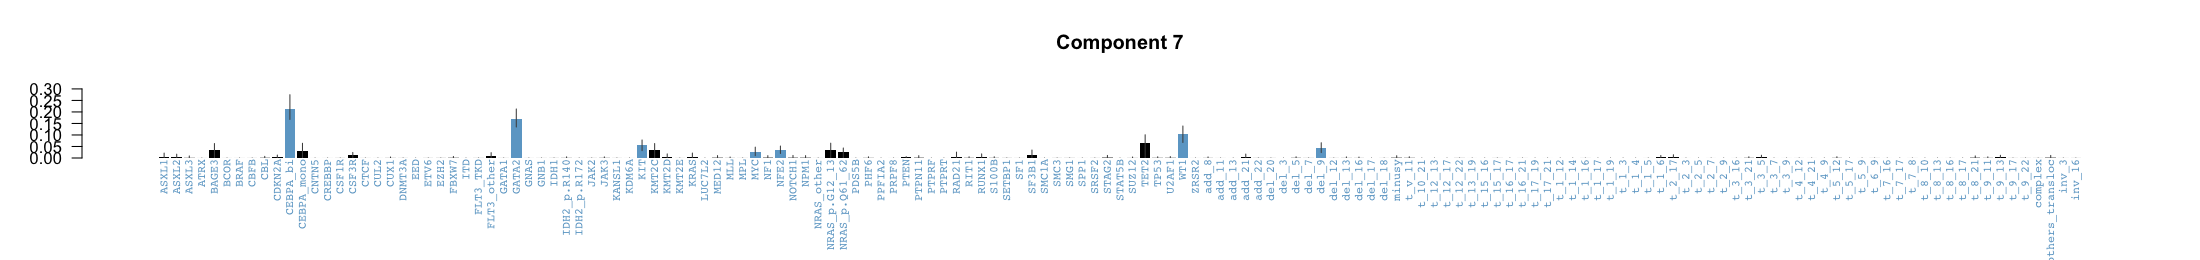

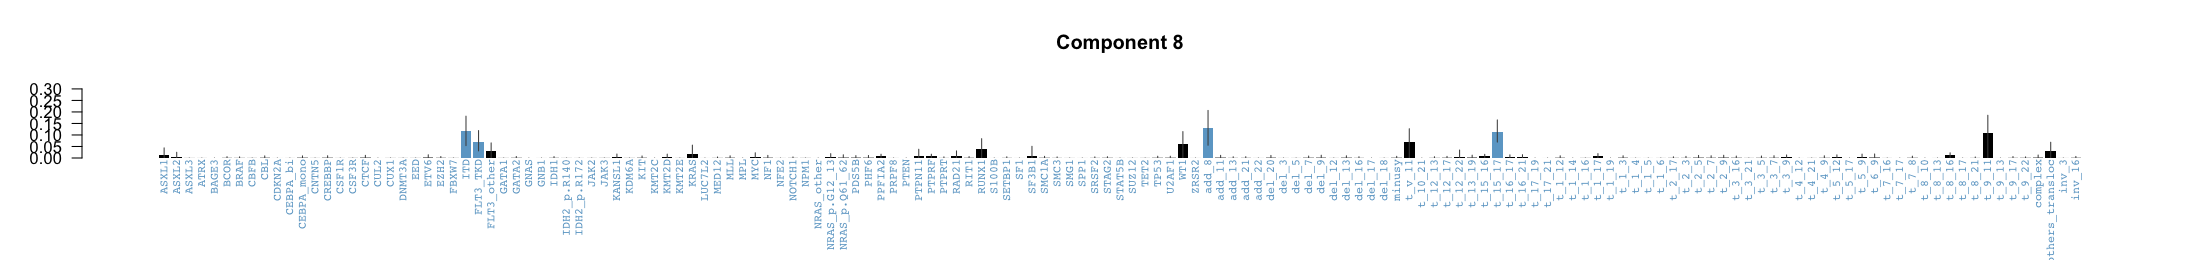

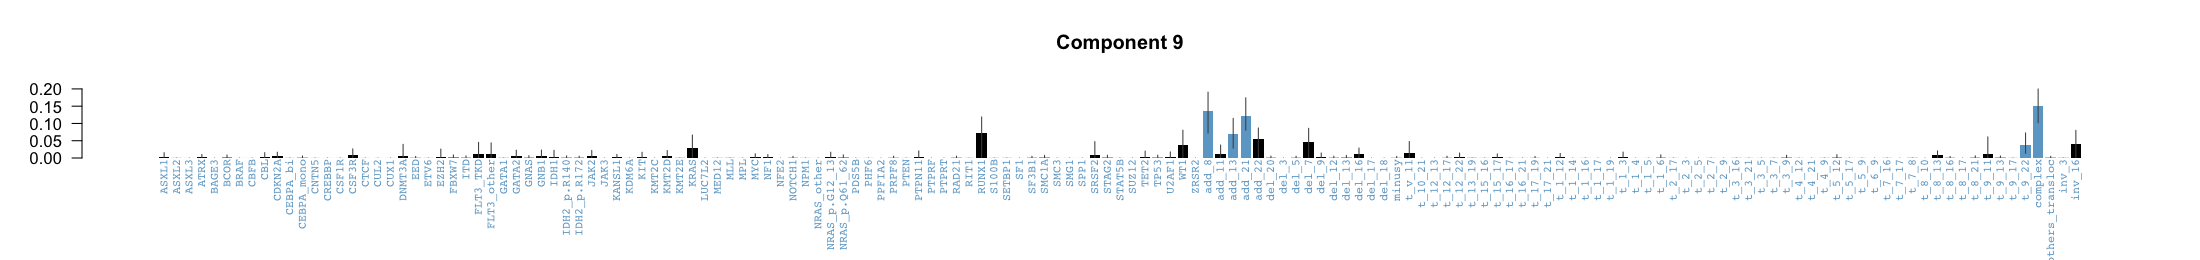

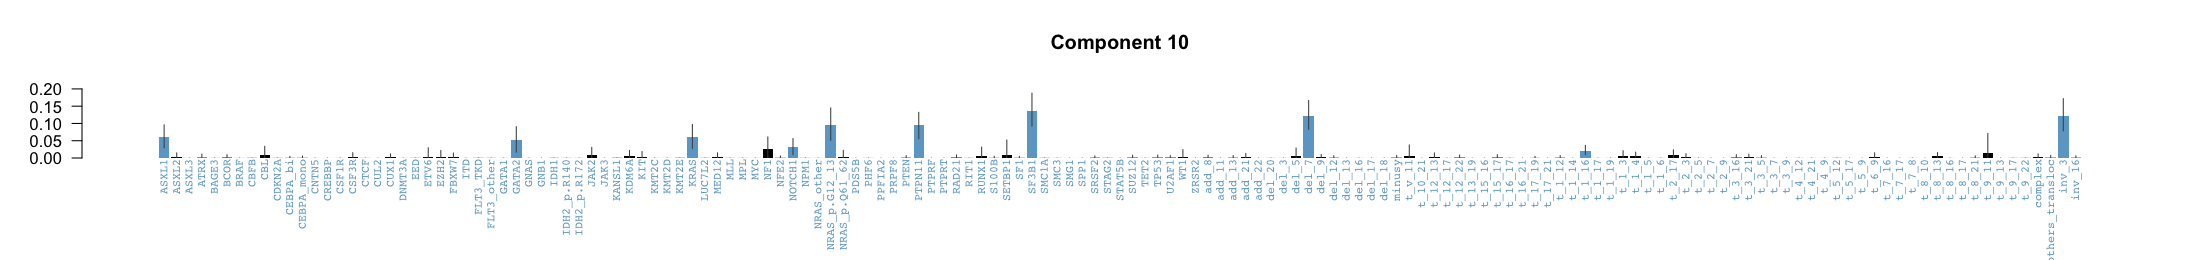

In [17]:

multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

# get table
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
tab <- get_table(dd_predicted_10_components[,'predicted_component'])
tab


#plot components
plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
plot_comp_distn(multi_output_cluster_10,
                cat_names  = colnames(df_final),
                col        = "skyblue3",
                col_nonsig = "black",
                                     )



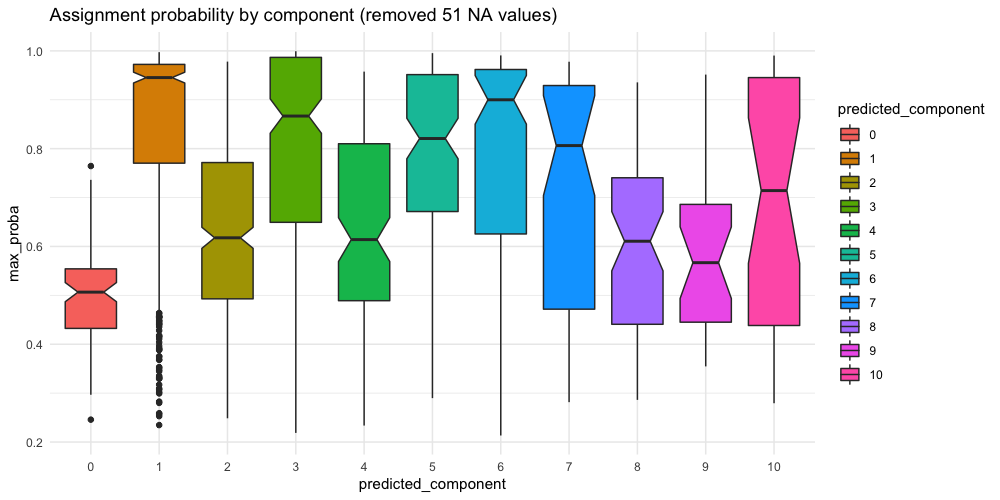

In [18]:
plot_assignement_probability_by_component(dd_predicted_10_components)